In [97]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
hiv1625 = pd.read_csv('/home/kristy/Downloads/newHIV/1625Data.txt', index_col=None, header=None, names=['octomer', 'flag'])

In [3]:
hiv1625.head()

,octomer,flag
0,SLNLRETN,1
1,AECFRIFD,1
2,HLVEALYL,1
3,TQIMFETF,1
4,AEELAEIF,1


In [4]:
hiv1625.dtypes

octomer    object
flag        int64
dtype: object

# Define features 

In [7]:
labels = hiv1625.flag
print labels.shape
print type(labels)

(1625,)
<class 'pandas.core.series.Series'>


In [8]:
octomers = hiv1625.octomer
print octomers.shape
print type(octomers)

(1625,)
<class 'pandas.core.series.Series'>


In [80]:
residues = pd.DataFrame(dtype=str, index=octomers.index, columns=['aa0','aa1','aa2','aa3','aa4','aa5','aa6','aa7'])

for idx, col in enumerate(residues.columns):
    residues[col] = octomers.apply(lambda x: x[idx])

In [81]:
residues.head()

,aa0,aa1,aa2,aa3,aa4,aa5,aa6,aa7
0,S,L,N,L,R,E,T,N
1,A,E,C,F,R,I,F,D
2,H,L,V,E,A,L,Y,L
3,T,Q,I,M,F,E,T,F
4,A,E,E,L,A,E,I,F


In [110]:
print sorted(residues.aa0.unique())

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [111]:
print sorted(residues.aa1.unique())

['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [112]:
le = LabelEncoder()
le.fit(sorted(residues.aa0.unique()))

for col in residues.columns:
    residues[col] = le.fit_transform(residues[col])

In [113]:
residues.head()

,aa0,aa1,aa2,aa3,aa4,aa5,aa6,aa7
0,15,9,11,9,14,3,16,11
1,0,3,1,4,14,7,4,2
2,6,9,17,3,0,9,19,9
3,16,13,7,10,4,3,16,4
4,0,3,3,9,0,3,7,4


In [114]:
aa1_split = pd.get_dummies(residues.aa1)

In [115]:
aa1_split.shape

(1625, 20)

In [116]:
aa1_split.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype='int64')

# Split into training and validation sets 

In [64]:
train_features, valid_features, train_labels, valid_labels = train_test_split(residues, labels)

# Create model

## Logistic regression 

In [66]:
reg = LogisticRegression()
reg.fit(X=train_features, y=train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [70]:
reg.intercept_

array([-1.95388909])

In [74]:
reg.coef_

array([[-0.00308556, -0.06212557,  0.08028553,  0.05072906,  0.01548123,
        -0.06025561, -0.01305022,  0.0453279 ]])

# Exploratory data analysis

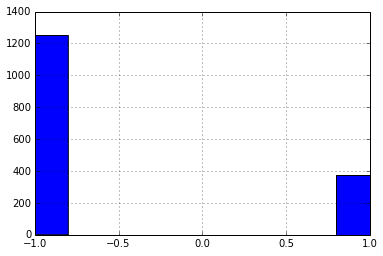

In [98]:
labels.hist();

In [99]:
labels.value_counts()

-1    1250
 1     375
dtype: int64

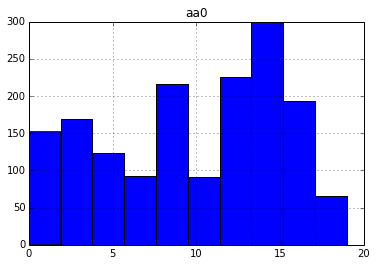

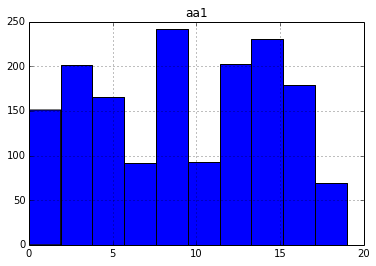

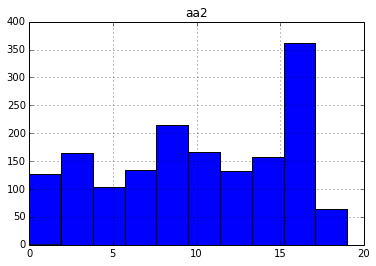

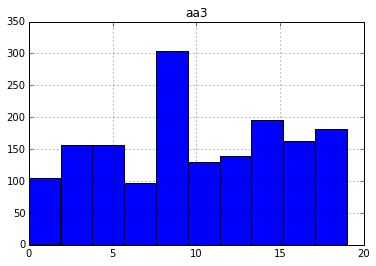

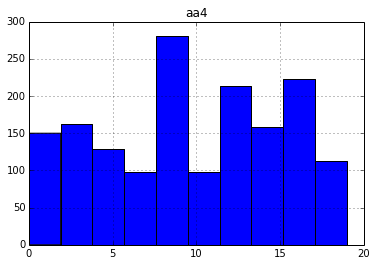

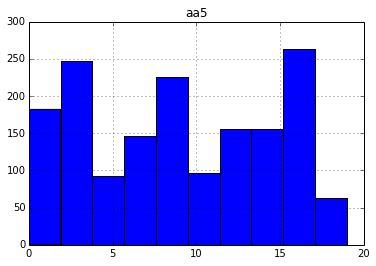

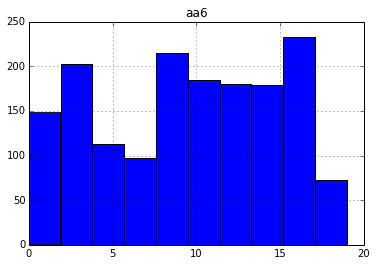

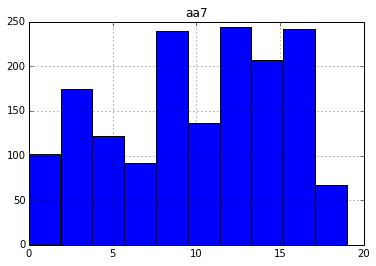

In [120]:
for i, col in enumerate(residues.columns):
    plt.figure(i)
    residues[col].hist();
    plt.title(col);

In [135]:
labeled = residues.append(hiv1625.flag)

In [137]:
hiv1625.flag.head()

0    1
1    1
2    1
3    1
4    1
Name: flag, dtype: int64

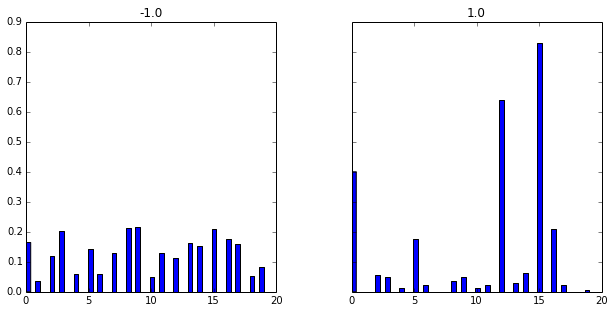

In [142]:
labeled.hist(column='aa0', by=hiv1625.flag, sharey=True, normed=True);

In [150]:
residues['label'] = hiv1625['flag']

In [151]:
residues.head()

,aa0,aa1,aa2,aa3,aa4,aa5,aa6,aa7,label
0,15,9,11,9,14,3,16,11,1
1,0,3,1,4,14,7,4,2,1
2,6,9,17,3,0,9,19,9,1
3,16,13,7,10,4,3,16,4,1
4,0,3,3,9,0,3,7,4,1


In [156]:
residues.pivot_table(rows='aa0', cols='label', aggfunc='count')

aa0       aa1       aa2       aa3       aa4       aa5       aa6       \
label   -1    1   -1    1   -1    1   -1    1   -1    1   -1    1   -1    1   
aa0                                                                           
0       78   57   78   57   78   57   78   57   78   57   78   57   78   57   
1       17  NaN   17  NaN   17  NaN   17  NaN   17  NaN   17  NaN   17  NaN   
2       57    8   57    8   57    8   57    8   57    8   57    8   57    8   
3       97    7   97    7   97    7   97    7   97    7   97    7   97    7   
4       28    2   28    2   28    2   28    2   28    2   28    2   28    2   
5       68   25   68   25   68   25   68   25   68   25   68   25   68   25   
6       28    3   28    3   28    3   28    3   28    3   28    3   28    3   
7       61  NaN   61  NaN   61  NaN   61  NaN   61  NaN   61  NaN   61  NaN   
8      101    5  101    5  101    5  101    5  101    5  101    5  101    5   
9      103    7  103    7  103    7  103    7  103    7  103    7  103    7   
10      24    2   24    2   24    2   24    2   24    2   24    2   24    2   
11      62    3   62    3   62    3   62    3   62    3   62    3   62    3   
12      53   91   53   91   53   91   53   91   53   91   53   91   53   91   
13      77    4   77    4   77    4   77    4   77    4   77    4   77    4   
14      72    9   72    9   72    9   72    9   72    9   72    9   72    9   
15     100  118  100  118  100  118  100  118  100  118  100  118  100  118   
16      84   30   84   30   84   30   84   30   84   30   84   30   84   30   
17      76    3   76    3   76    3   76    3   76    3   76    3   76    3   
18      25  NaN   25  NaN   25  NaN   25  NaN   25  NaN   25  NaN   25  NaN   
19      39    1   39    1   39    1   39    1   39    1   39    1   39    1   

       aa7       label       
label   -1    1     -1    1  
aa0                          
0       78   57     78   57  
1       17  NaN     17  NaN  
2       57    8     57    8  
3       97    7     97    7  
4       28    2     28    2  
5       68   25     68   25  
6       28    3     28    3  
7       61  NaN     61  NaN  
8      101    5    101    5  
9      103    7    103    7  
10      24    2     24    2  
11      62    3     62    3  
12      53   91     53   91  
13      77    4     77    4  
14      72    9     72    9  
15     100  118    100  118  
16      84   30     84   30  
17      76    3     76    3  
18      25  NaN     25  NaN  
19      39    1     39    1  

[20 rows x 18 columns]